In [1]:
### Risk-Based Maintenance Prioritization Using NASA Turbofan Data

In [2]:
### Risk-Based Maintenance Prioritization Using NASA Turbofan Data

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [4]:
# Load Raw Text Data
columns = (
    ['engine_id', 'cycle'] +
    ['op_setting_1', 'op_setting_2', 'op_setting_3'] +
    [f'sensor_{i}' for i in range(1, 22)]
)

df = pd.read_csv(
    '/content/train_FD001.txt' ,
    sep=r'\s+',
    header=None,
    names=columns
)


In [5]:
df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [6]:
df.shape


(20631, 26)

In [7]:
# Understand Engine Lifecycle
df['engine_id'].nunique()

100

In [8]:
# Distribution of engine lifetimes
engine_life = df.groupby('engine_id')['cycle'].max()

engine_life.describe()


,cycle
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [9]:
# Create RUL (TARGET ENGINEERING)
# Create Remaining Useful Life (RUL)
df['max_cycle'] = df.groupby('engine_id')['cycle'].transform('max')
df['RUL'] = df['max_cycle'] - df['cycle']

df[['engine_id', 'cycle', 'max_cycle', 'RUL']].head()


,engine_id,cycle,max_cycle,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [10]:
# Create Failure Risk Label
# Define near-term failure risk
FAILURE_WINDOW = 25  # cycles

df['failure_risk_25'] = (df['RUL'] <= FAILURE_WINDOW).astype(int)

df[['engine_id', 'cycle', 'RUL', 'failure_risk_25']].head(30)


,engine_id,cycle,RUL,failure_risk_25
0,1,1,191,0
1,1,2,190,0
2,1,3,189,0
3,1,4,188,0
4,1,5,187,0
5,1,6,186,0
6,1,7,185,0
7,1,8,184,0
8,1,9,183,0
9,1,10,182,0


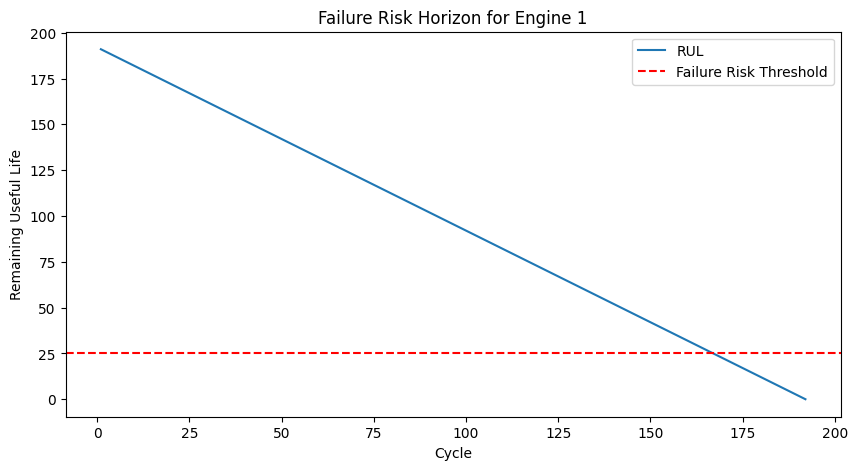

In [11]:
# VISUALIZE FAILURE RISK ZONE
engine_df = df[df['engine_id'] == 1]

plt.figure(figsize=(10,5))
plt.plot(engine_df['cycle'], engine_df['RUL'], label='RUL')
plt.axhline(y=FAILURE_WINDOW, color='r', linestyle='--', label='Failure Risk Threshold')
plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life')
plt.title('Failure Risk Horizon for Engine 1')
plt.legend()
plt.show()


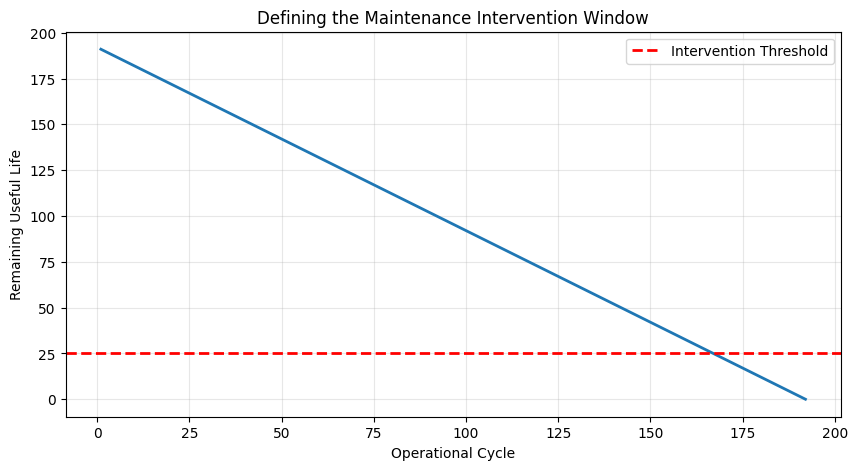

In [12]:
plt.figure(figsize=(10,5))
plt.plot(engine_df['cycle'], engine_df['RUL'], linewidth=2)
plt.axhline(
    y=FAILURE_WINDOW,
    color='red',
    linestyle='--',
    linewidth=2,
    label='Intervention Threshold'
)
plt.xlabel('Operational Cycle')
plt.ylabel('Remaining Useful Life')
plt.title('Defining the Maintenance Intervention Window')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


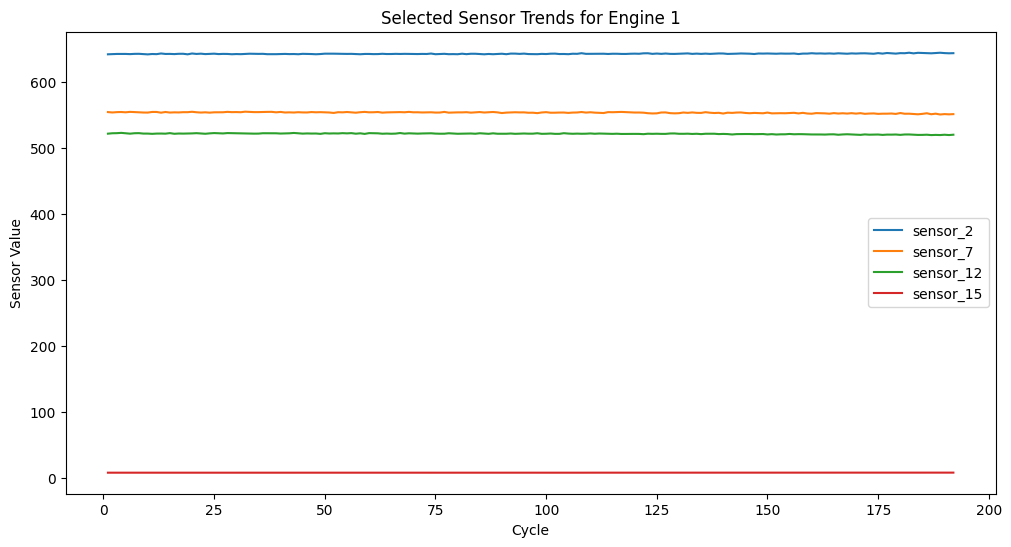

In [13]:
# SENSOR BEHAVIOR ANALYSIS
# Identify candidate sensors visually
sensor_cols = [c for c in df.columns if 'sensor_' in c]

# Plot a few sensors for one engine
engine_df = df[df['engine_id'] == 1]

plt.figure(figsize=(12,6))
for s in ['sensor_2', 'sensor_7', 'sensor_12', 'sensor_15']:
    plt.plot(engine_df['cycle'], engine_df[s], label=s)

plt.xlabel('Cycle')
plt.ylabel('Sensor Value')
plt.title('Selected Sensor Trends for Engine 1')
plt.legend()
plt.show()


In [14]:
# FEATURE ENGINEERING (CORE DIFFERENTIATOR)
# RATE OF CHANGE
df['sensor_2_rate'] = df.groupby('engine_id')['sensor_2'].diff()


In [15]:
# ROLLING STRESS INDICATOR
df['sensor_7_roll_mean'] = (
    df.groupby('engine_id')['sensor_7']
      .rolling(window=5)
      .mean()
      .reset_index(level=0, drop=True)
)


In [16]:
# SENSOR INSTABILITY (VOLATILITY)
df['sensor_12_volatility'] = (
    df.groupby('engine_id')['sensor_12']
      .rolling(window=5)
      .std()
      .reset_index(level=0, drop=True)
)


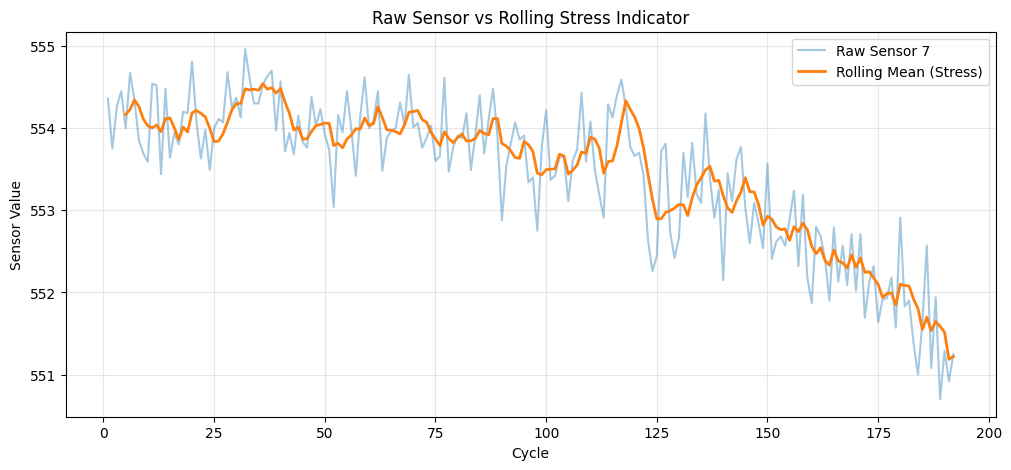

In [17]:
# VISUALIZE ENGINEERED FEATURES
engine_df = df[df['engine_id'] == 1]

plt.figure(figsize=(12,5))
plt.plot(engine_df['cycle'], engine_df['sensor_7'], alpha=0.4, label='Raw Sensor 7')
plt.plot(engine_df['cycle'], engine_df['sensor_7_roll_mean'], linewidth=2, label='Rolling Mean (Stress)')
plt.xlabel('Cycle')
plt.ylabel('Sensor Value')
plt.title('Raw Sensor vs Rolling Stress Indicator')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [18]:
# PREPARE DATASET FOR ML
# Drop NaNs
df_model = df.dropna().copy()

df_model.shape


(20231, 32)

In [19]:
# Select Final Feature Set
features = [
    'sensor_2_rate',
    'sensor_7_roll_mean',
    'sensor_12_volatility',
    'sensor_15'
]

X = df_model[features]
y = df_model['failure_risk_25']

X.head(), y.head()


(   sensor_2_rate  sensor_7_roll_mean  sensor_12_volatility  sensor_15
 4           0.02             554.164              0.432574     8.4294
 5          -0.27             554.226              0.425417     8.4108
 6           0.38             554.344              0.425652     8.3974
 7           0.08             554.262              0.429919     8.4076
 8          -0.44             554.110              0.341101     8.3728,
 4    0
 5    0
 6    0
 7    0
 8    0
 Name: failure_risk_25, dtype: int64)

In [20]:
# TRAIN / TEST SPLIT
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(
    gss.split(X, y, groups=df_model['engine_id'])
)

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

X_train.shape, X_test.shape


((16241, 4), (3990, 4))

In [21]:
# TRAIN THE MODEL
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

In [22]:
# Generate Predictions
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3470
           1       0.84      0.79      0.82       520

    accuracy                           0.95      3990
   macro avg       0.91      0.89      0.90      3990
weighted avg       0.95      0.95      0.95      3990



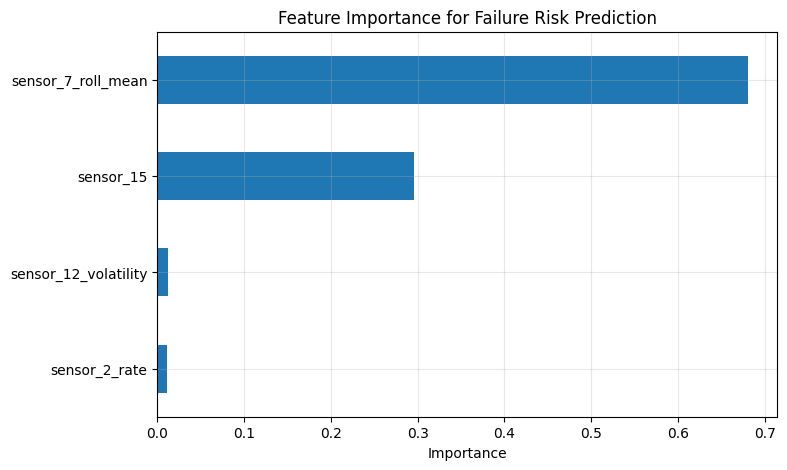

In [23]:
# Feature Importance Plot
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(
    model.feature_importances_,
    index=features
).sort_values()

plt.figure(figsize=(8,5))
importance.plot(kind='barh')
plt.xlabel('Importance')
plt.title('Feature Importance for Failure Risk Prediction')
plt.grid(alpha=0.3)
plt.show()


In [24]:
# RISK-WEIGHTED MAINTENANCE PRIORITY SCORE
# Predict failure probability
df_model['failure_prob'] = model.predict_proba(X)[:, 1]


In [25]:
# Define urgency (time pressure)
df_model['urgency'] = 1 / (df_model['RUL'] + 1)


In [26]:
# Final Risk Priority Score
df_model['risk_priority_score'] = (
    0.5 * df_model['failure_prob'] +
    0.3 * df_model['sensor_7_roll_mean'].rank(pct=True) +
    0.2 * df_model['urgency']
)


In [27]:
priority_table = (
    df_model.groupby('engine_id')
            .agg({'risk_priority_score': 'max'})
            .sort_values(by='risk_priority_score', ascending=False)
)


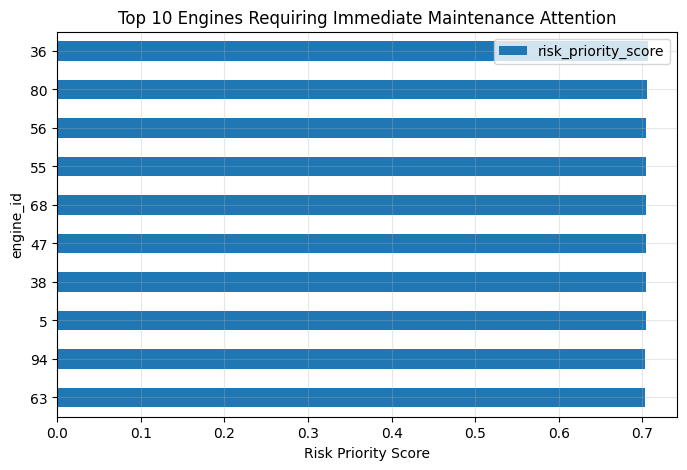

In [28]:
priority_table.head(10).sort_values(
    by='risk_priority_score'
).plot(
    kind='barh',
    figsize=(8,5)
)

plt.xlabel('Risk Priority Score')
plt.title('Top 10 Engines Requiring Immediate Maintenance Attention')
plt.grid(alpha=0.3)
plt.show()


🔧 **Project Overview**

**Risk-Based Maintenance Prioritization Using Engine Degradation Data**



*   Objective:
              Transform raw engine sensor data into an actionable system that identifies which assets require immediate maintenance attention.

*   Dataset:
            NASA CMAPSS turbofan engine degradation dataset covering full lifecycles of 100 engines with varying operational durations.

* Problem Framing:
                  Instead of predicting exact Remaining Useful Life (RUL), the task was reframed as a near-term failure risk classification problem using a 25-cycle intervention window.


**📊 Exploratory Insights**

*   Engine lifetimes varied significantly, demonstrating that fixed maintenance thresholds are ineffective.
* Raw sensor signals were noisy and weakly informative.
* Engineered features revealed clear degradation patterns close to failure.


**Feature Engineering Strategy:**


*   Sustained Stress: Rolling averages to capture long-term operational load
*   Instability: Sensor volatility to detect irregular behavior
*   Degradation Dynamics: Rate-of-change features to represent wear acceleration


**🤖 Modeling Approach:**


*   Model: Random Forest Classifier
*   Validation: Engine-level train/test split to prevent lifecycle leakage
*   Performance Focus: Recall prioritized for failure cases to reduce missed breakdowns
*   Result: ~79% recall for near-term failure prediction


**🔍 Model Interpretability:**

1. Feature importance analysis showed that:


*   Sustained stress patterns were the strongest predictors of failure risk
*   Volatility and rate-based features provided complementary signals



2. Results aligned with domain expectations, increasing model trustworthiness


**🚀 Decision-Oriented Output:**

1. Developed a risk-weighted maintenance priority score combining:


*   Failure probability
*   Relative stress intensity
*   Urgency based on remaining life


**Key Takeaway:**

Predictive models create value only when translated into decisions.

This project demonstrates how machine learning and feature engineering can support proactive, prioritized maintenance strategies.

















